<a href="https://colab.research.google.com/github/hongrolee/Python/blob/main/colab/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%95%99%EC%83%81%EB%B8%94_%EB%B0%8F_%EB%B9%84%EC%A0%95%ED%98%95_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%B2%98%EB%A6%AC_%EC%8B%A4%EC%8A%B5%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SetUp

In [ ]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# sn.set()

# 폰트출력
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

Mounted at /content/drive


In [ ]:
from matplotlib.colors import ListedColormap
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

# **I. 앙상블 학습과 랜덤 포레스트**

**앙상블(ensemble)**
*   **앙상블** :프랑스어이며 뜻은 *조화* 또는 *통일*을 의미
*   **앙상블 학습** : 머신러닝에서 여러개의 모델을 학습시켜 그 모델들의 예측결과들을 이용해 하나의 모델보다 더 나은 값을 예측하는 방법

**앙상블 학습의 대표적인 예**
*   **랜덤 포레스트**(Random Forest) : 여러개의 의사결정나무(decision tree)들을 생성한 다음, 각 개별 트리의 예측값들 중에서 가장 많은 선택을 받은 클래스(또는 label)로 예측하는 알고리즘

*   그 밖의 **배깅, 부스팅, 스태킹** 등

## **1. 투표 기반 분류기(Voting Classifier)**

 * 학습 단계에서 여러개의 머신러닝 알고리즘 모델을 학습시킨 후 이러한 모델들을 이용해 새로운 데이터에 대해 각 모델의 예측값을 가지고 **다수결 투표**를 통해 최종 클래스를 예측하는 방법( **직접 투표**(hard voting) 분류기)
* 이러한 다수결 투표 분류기가 앙상블에 포함된 개별 분류기(아래 그림에서는 LR, RF, SVM, ...) 중 가장 성능이 좋은 분류기보다 정확도가 더 높을 경우가 많음
<img src="https://drive.google.com/uc?id=1vl8Q8f0R8uJN_w1EFfmGfhfMGqZ-TNXB"><br>

### **1) 투표 분류기가 더 좋은 이유**

* 동전 던지기의 예
  - 앞면이 나올 확률이 51%
  - 뒷면이 나올 확률이 49%
  - 총 1,000번 던지면 약 510번은 앞면, 490번은 뒷면(더 많은 횟수로 앞면이 나온다는 것을 알 수 있음)
  - 수학적으로 계산해보면 1,000번을 던진 후 앞면이 더 많이 나올 확률은 75%에 가까운 것을 알 수 있다. 동전 던지기는 이항분포이므로 다음과 같이 나타낼 수 있음
$$
\binom{n}{k} p^{k}\left( 1-p \right)^{n-k}
$$
  - 위의 식을 이용해 0~499 까지의 누적 분포 함수(CDF, Cumulative Distribution Function)를 이용해 누적 확률을 계산한 뒤, 전체 확률 1에서 빼주면 75%를 구할 수 있음
  - 즉, 동전을 10,000번 던진다면 앞면이 더 많이 나올 확률이 97%(`1 - scipy.stats.binom.cdf(4999, 10000, 0.51)`) 이상으로 올라감


* 앙상블의 경우
  - 이와 비슷하게 51% 정확도를 가진 1,000개의 분류기로 앙상블 모델을 구축할 경우 정확도는 75%
  - 그러나 이러한 가정은 모든 분류기가 독립적이어야 하고, 오차에 대해 상관관계가 없어야 함
  - 따라서, 앙상블 기법에서 독립적인 모델을 만들어 주기 위해서는 다른 머신러닝 알고리즘으로 학습시키는 것이 좋음. 그 이유는 모델 별로 다른 종류의 오차를 가지므로 상관관계가 작아지기 때문

> 예제) 동전을 던져 앞면이 나온 비율

In [ ]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

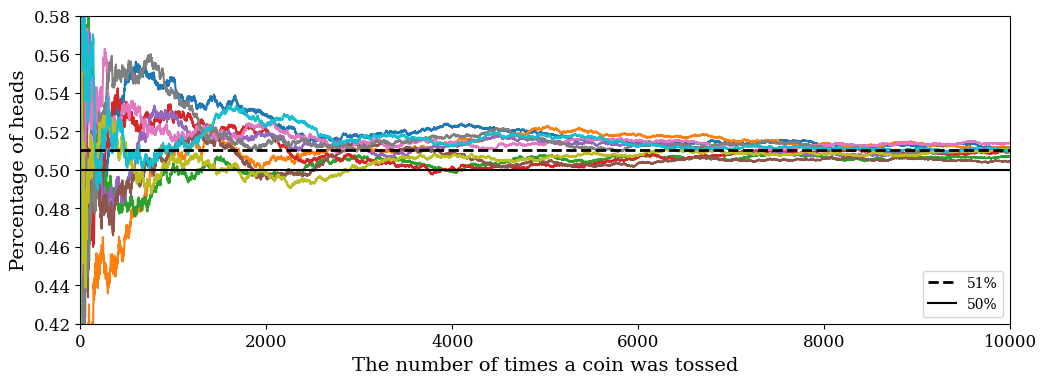

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("The number of times a coin was tossed")
plt.ylabel("Percentage of heads")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

### **2) moons 데이터셋에 앙상블 학습 적용하기**

위에서 살펴본 투표 분류기를 Scikit-Learn의 [`VotingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)를 이용해 예제 데이터셋인 `moons`데이터 셋에 적용해보자. `moons` 데이터셋은 Scikit-Learn에서 제공하는 반달 모양의 데이터셋

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

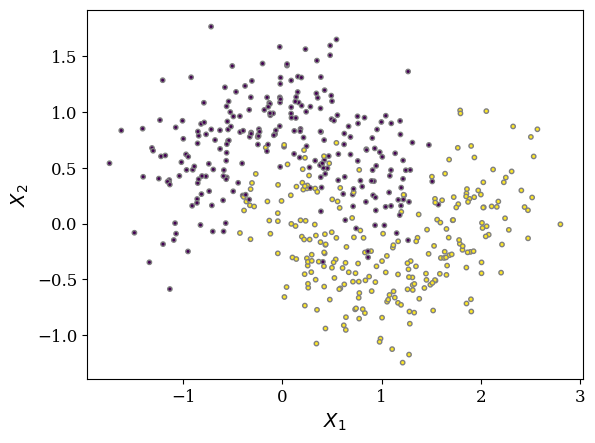

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=10,
            edgecolor="gray", linewidth=1)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

### **3) Hard voting**

`VotingClassifier`에서 `voting='hard'` 인 경우 각 분류기의 예측값(레이블)을 가지고 다수결 투표를 통해 최종 앙상블 예측
<br> ex> '김태희'와 '송혜교'의 분류라면 10개의 분류기 중 6개가 '김태희'면 최종결론은 '김태희'
* VotingClassifier(
    estimators=[(model_naming, model), ..., (model_naming, model)],
    voting='hard')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)







VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


### **4) Soft voting**

`VotingClassifier`에서 `voting='soft'` 인 경우 각 분류기의 예측값(레이블)의 확률을 가지고 평균을 구한 뒤, 평균이 가장 높은 클래스로 최종 앙상블 예측
<br> ex> '김태희'와 '송혜교'의 분류라면
* 1st 분류기 : 0.7, 0.3
* 2nd 분류기 : 0.5, 0.5
* 3rd 분류기 : 0.6, 0.4
* 평균 = (0.7+0.5+0.6)/3, (0.3+0.5+0.4)/3
<br>  = 0.6, 0.4
* 최종 김태희 선택


In [ ]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)



VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## **2. 배깅과 페이스팅 (Bagging and Pasting)**

하나의 알고리즘을 사용하지만 훈련 세트의 서브셋을 랜덤하게 구성하여 모델(분류기)을 각각 다르게 학습시키는 방법

학습 데이터셋에서 랜덤하게 추출할 때
* **배깅(bagging)** 중복을 허용하는 방식
  - 통계학에서는 중복을 허용한 리샘플링(resampling)을 **부트스트래핑**(bootstraping)
* **페이스팅(pasting)** : 중복을 허용하지 않는 방식

<img src = "https://drive.google.com/uc?id=1ey6LEfhwq5ucEufchXC5Xq1_UGlzDnn5"><br>

각 모델이 학습된 후에 새로운 데이터에 대해서는
* 분류(classification)일 경우 : **통계적 최빈값(mode)** 즉, 가장 많은 예측 클래스로 앙상블이 예측(voting과 동일)
* 회귀(regression)일 경우 : 각 분류기의 예측값의 평균을 계산하여 평균값을 예측

각 모델은 전체 학습 데이터셋으로 학습시킨 것보다  **앙상블을 통해 편향(bias)과 분산(variance)이 감소**한다. (일반적으로 앙상블 학습은 전체 학습 데이터셋을 이용해 하나의 모델을 학습시킬 때와 비교해서 편향은 비슷하지만 분산은 줄어든다.)

### **1) 사이킷런의 배깅과 페이스팅**

* BaggingClassifier : 분류의 경우
* BaggingRegressor : 회귀의 경우

아래의 예제는 '투표기반 분류기'에서 다룬 `moons` 데이터셋을 `BaggingClassifier`를 이용해 500개의 의사결정나무(decision tree)모델을 만들어 배깅을 적용한 앙상블 학습을 한 예제이다.

#### 단 하나의 Decision Tree를 사용할 경우

Accuracy = 0.856


#### Bagging 기반의 앙상블 학습을 사용할 경우

이번에는 `BaggingClassifier`를 이용해 500개의 의사결정나무 모델을 만들어 보자. `BaggingClassifier`는 사용하는 알고리즘 모델(분류기)이 각 예측 클래스의 확률을 추정할 수 있으면, 직접 투표(hard voting)대신 간접 투표(soft voting) 방식을 사용한다.

Accuracy = 0.904


결정 경계(decision boundary) 비교 그래프 : <하나의 의사결정나무에 대한 결정 경계>와 <배깅을 이용한 앙상블 트리에 대한 결정 경계>

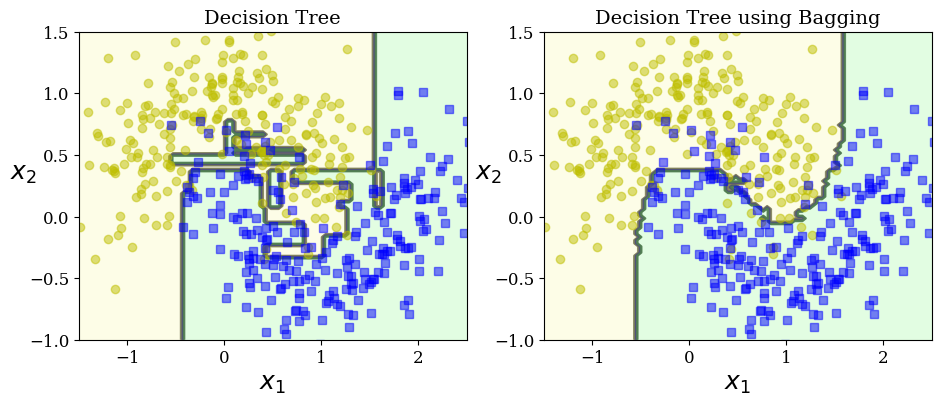

In [ ]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Tree using Bagging", fontsize=14)
plt.show()

### **2) OOB(Out-of-Bag) 평가**

* 배깅은 중복을 허용하는 리샘플링(resampling)
  - 즉, 부트스트래핑(bootstraping) 방식이기 때문에 전체 학습 데이터셋에서 어떠한 데이터 샘플은 여러번 샘플링 되고, 또 어떠한 샘플은 전혀 샘플링 되지 않을 수가 있음
* **샘플링 되지 않은 나머지 샘플들을 oob(out-of-bag) 샘플**
  - 평균적으로 학습 단계에서 전체 학습 데이터셋 중 63% 정도만 샘플링 됨

* 앙상블(배깅) 모델의 학습 단계에서는 oob 샘플이 사용되지 않기 때문에, 이러한 **oob 샘플을 검증세트(validation set) 또는 교차검증(cross validation)에 사용 가능**

* Scikit-Learn에서는 `BaggingClassifier`의 인자인 `oob_score=True`로 설정하면 학습이 끝난 후 자동으로 oob 평가를 할 수 있음

아래는 `moons` 데이터셋을 `BaggingClassifier`를 적용한 후 oob 평가를 해준 것

oob score : 0.8986666666666666


oob 샘플에 대한 결정 함수(decision function) 값도 확인 가능

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

## **3. 랜덤 포레스트 (Random Forest)**
> <정의>
* 배깅(bagging)을 적용한 의사결정트리(decision tree)의 앙상블
* 의사결정트리를 랜덤하게 만들어 결정트리의 숲(forest)을 만듦

> <숲(forest) 구성 과정>
* 샘플 추출 방법 : Train Set에서 랜덤하게 중복을 허용하여 샘플을 추출
  - 이 때 뽑혀진 샘플을 부트스트랩 **부트스트랩 샘플(bootstrap sample)**이라 함
* 노드 분할 방법 : 전체 특성 중 일부 특성을 랜덤하게 선택하여 최선의 분할을 찾아 노드를 구성
  - RandomForestClassifier의 경우, 전체 특성 개수의 제곱근만큼의 특성 선택
* 분류 방법 : 각 트리의 클래스별 확률을 평균하여 가장 높은 확률을 가진 클래스로 분류
* 회귀 방법 : 각 트리의 예측 결과를 평균하여 예측값 도출

> <장점>
* 랜덤하게 샘플과 특성을 추출하기 때문에 훈련 세트에 과대적합되는 것을 방지
* Scikit-Learn에서 RandomForestClassifier 제공

### <예제> 화이트 와인 분류

In [ ]:
# 데이터 읽어오기 (wine.csv)







In [ ]:
# 데이터 분리




In [ ]:
# 랜덤포레스트를 이용하여 훈련







In [ ]:
# 성능 측정(훈련 및 검증 결과)



0.9973541965122431 0.8905151032797809


In [ ]:
# 특성 중요도 확인





[0.23167441 0.50039841 0.26792718]


In [ ]:
# Out of Bag 점수 확인 (oob_score=True)






0.8934000384837406


### Moon 데이터 분류 (Bagging과 Random Forest 비교)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:




# Random Forest




# BaggingClassifier를 활용하여 Random Forest와 유사하게 구현





# 두 모델의 예측 비교



0.912
0.92
0.976


붓꽃(iris) 데이터셋을 `RandomForestClassifier`를 이용해 학습시키고 각 특성의 중요도를 출력하는 예제

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


### **2) 엑스트라 트리 (Extremely Randomized Trees)**
**<랜덤 포레스트와의 차이점>**
* 샘플을 선택하는 방법 : 부트스트랩 샘플을 사용하지 않고 전체 훈련 세트를 사용
* 노드를 분할하는 방법 : 무작위로 분할
* 많은 트리를 앙상블하기 때문에 과대적합을 막고, 검증 세트의 점수를 높이는 효과
* 훨씬 빠른 훈련 속도

  * 분류 : ExtraTreesClassifier
  * 회귀 : ExtraTreesRegressor

랜덤 포레스트는 트리를 생성할 때, 각 노드는 랜덤하게 특성(feature)의 서브셋(자식 노드를)을 만들어 분할한다. 반면 **익스트림 랜덤 트리**(Extremely Randomized Trees) 또는 **엑스트라 트리**(Extra-Trees)는 트리를 더욱 랜덤하게 생성하기 위해 노드를 분할하는 최적의 임계값을 찾는 것이 아니라 후보 특성을 이용해 랜덤하게 분할한 다음 그 중에서 최상의 분할을 선택하는 방법이다. 랜덤 포레스트 처럼 각 노드의 특성마다 최적의 임계값을 찾는것이 아니기 때문에 엑스트라 트리가 **훨씬 학습 속도가 빠르다.**

Scikit-Learn에서는 [`ExtraTreesClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)을 이용해 엑스트라 트리를 구현할 수 있다.

와인 데이터로 엑스트라트리 테스트하기

In [ ]:
# 데이터 읽어오기 (wine.csv)




In [ ]:
# 데이터 분리




In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_validate







0.9974503966084433 0.8887848893166506


[0.20183568 0.52242907 0.27573525]


## **4. 부스팅 (boosting)**

* **부스팅**(boosting) : 성능이 약한 학습기(weak learner)를 여러 개 연결하여 강한 학습기(strong learner)를 만드는 앙상블 학습법

* 기본 아이디어 : 앞에서 학습된 모델을 보완해나가면서 더 나은 모델로 학습시키는 것

* 부스팅 방법 : **에이다부스트**(AdaBoost, Adaptive Boosting)와 **그레이디언트 부스팅**(Gradient Boosting), **히스토그램 기반 부스팅**

### **1) 에이다부스트 (AdaBoost)**

* **에이다부스트(AdaBoost)** : 과소적합(underfitted)됐던 학습 데이터 샘플의 가중치를 높이면서 새로 학습된 모델이 학습하기 어려운 데이터에 더 잘 적합되도록 하는 방식

1. 전제 학습 데이터셋을 이용해 모델을 만든 후, 잘못 예측(분류)된 샘플의 가중치를 상대적으로 높여준다.
2. 두 번째 모델을 학습 시킬 때 업데이트 된 가중치를 반영하여 모델을 학습 시킨다.
3. 이와 같은 과정을 반복한다.



<img src = "https://drive.google.com/uc?id=1y5hjAqsX3McxTY1ixuKIRKjq8DVLc1f6"><br>

#### moons 데이터셋에 AdaBoost 적용하기

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier








AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=200, random_state=42)

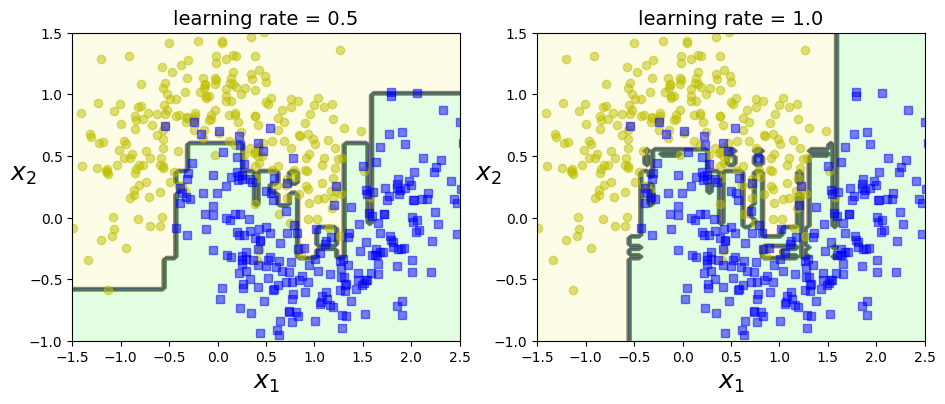

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(ada_clf_05, X, y)
plt.title("learning rate = 0.5", fontsize=14)
plt.subplot(122)
plot_decision_boundary(ada_clf_10, X, y)
plt.title("learning rate = 1.0", fontsize=14)
plt.show()

### **2) 그레이디언트 부스팅**
깊이가 얕은 결정트리를 사용하여 이전 트리의 오차를 보완하는 방식으로 앙상블하는 방법, 경사하강법을 사용하여 트리를 앙상블에 추가

* 깊이가 3인 결정트리를 100개 사용, 과대적합에 강함
* 높은 일반화 성능을 보임

<img src = "https://drive.google.com/uc?id=1K7dYx-_KCvg2ZbOEhm7JKGju89XNXD9X"><br>

#### 그레이디언트 부스팅 회귀에 적용해 보기
$$
y = 3X^{2} + 0.05 + \text{noise}
$$

그레이디언트 부스팅은 의사결정나무(decision tree) 알고리즘을 이용해 그레이디언트 부스팅을 사용하며, 이를 **그레이디언트 트리 부스팅** 또는 **그레이디언트 트리 부스팅** 또는 **그레이디언트 부스티드 회귀 트리(GRBT)**라고 한다.

`DecisionTreeRegressor` 을 사용

DecisionTreeRegressor(max_depth=2, random_state=42)

처음 학습시킨 모델 `tree_reg1`에 대한 잔여 오차(residual error)를 구한 뒤 이것을 가지고 두번째 `DecisionTreeRegressor`모델을 학습시킨다.

DecisionTreeRegressor(max_depth=2, random_state=42)

위와 같은 방법으로 두번째 모델에 대한 잔여 오차를 구해 세번째 모델을 학습시킨다.

DecisionTreeRegressor(max_depth=2, random_state=42)

이렇게 학습 시킨 그레이디언트 부스팅 모델에 새로운 데이터 `X_new = 0.8`에 대해 예측값을 구해보자.

y_pred : [0.75026781]


위의 과정을 그림으로 나타내면 아래와 같다.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPyt

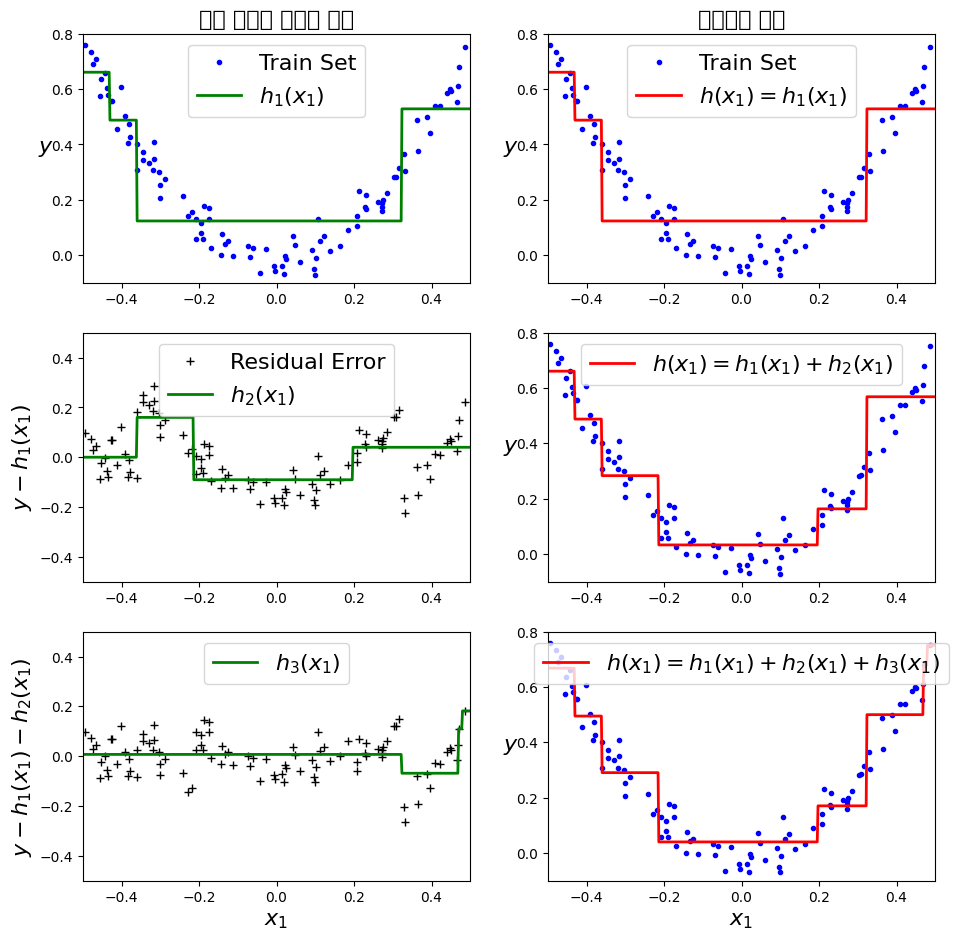

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Train Set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("잔여 오차와 트리의 예측", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Train Set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("앙상블의 예측", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residual Error")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

이번에는 Scikit-Learn의 [`GradientBoostingRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)를 이용해 위의 과정과 동일하게 모델링 해보자. 아래의 결과에서 볼 수 있듯이, `DecisionTreeRegressor`를 이용해 그래디언트 부스팅을 단계별로 수행한 것과 동일한것을 알 수 있다.

`GradientBoostingRegressor`에서 `learning_rate`($\eta$) 인자는 학습 단계에서 각 모델(트리)의 반영 비율을 의미한다.

$$
H_t(\mathbf{x}) = H_{t-1}(\mathbf{x}) + \eta h_t(\mathbf{x})
$$

- $\eta$의 값은 $0 < \eta \le 1$이며, 값이 작을 수록 학습을 위해 더 많은 모델(트리)가 필요하지만, 성능은 좋아진다.

이렇게 `learning_rate`($\eta$)를 이용하는 방법을 **축소**(shrinkage)라고 하는 규제(regularization) 방법이다.

학습시킬 모델의 개수(`n_estimator`)를 3개와 200개로 했을 때의 차이

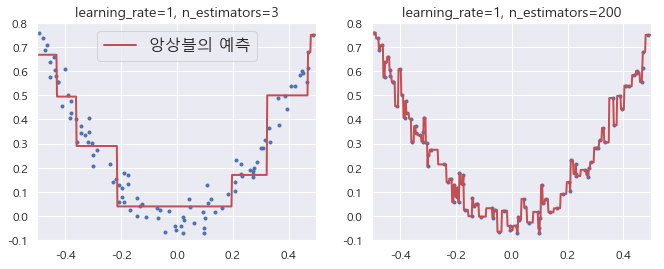

In [ ]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="앙상블의 예측")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

#### 조기종료(early stopping)을 이용한 그레이디언트 부스팅

그레이디언트 부스팅의 학습 단계에서 학습 시킬 최적의 트리(모델)의 개수를 찾기 위해 조기 종료(early stopping)을 사용할 수 있다.

아래의 예제는 GBRT를 학습시킨 후 `staged_predict()` 메소드를 이용해 각 모델의 예측값(`y_pred`)과 실제값(`y_val`)의 MSE를 구한 뒤 MSE가장 낮은 최적의 트리의 개수를 찾아 다시 최적의 트리 개수(`best_n_estimator`)로 그래디언트 부스팅을 학습시키는 예제이다.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# 최적의 트리 개수 찾기
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

# 최적의 트리개수로 그래디언트 부스팅 학습
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

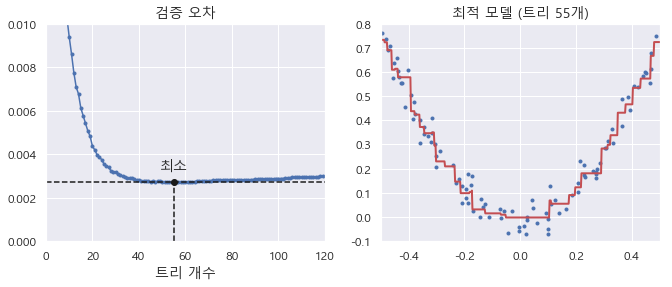

In [ ]:
min_error = np.min(errors)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "최소", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("트리 개수")
plt.title("검증 오차", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("최적 모델 (트리 %d개)" % bst_n_estimators, fontsize=14)

plt.show()

최적의 트리 개수를 찾았을 때, 학습을 조기종료하는 예제

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

In [ ]:
print('최적의 트리 개수 :', gbrt.n_estimators)
print("최소 검증 MSE:", min_val_error)

최적의 트리 개수 : 61
최소 검증 MSE: 0.002712853325235463


#### <실습> 와인 데이터에 그레이디언트 부스팅 적용
* 교차검증 점수 확인해보기
* 중요 특성 확인해보기



In [ ]:
# 데이터 읽어오기 (wine.csv)







In [ ]:
# 데이터 분리




### 3) 히스토그램 기반 부스팅

#### XGBoost

#### LightGBM

## **5. 스태킹 (Stacking)**

**스태킹**(stacking, stacked generalization의 줄임)은 '투표 기반 분류기'에서 처럼 'hard voting', 'soft voting' 방법이 아니라 앙상블 학습에서 각 모델의 예측값을 가지고 새로운 **메타 모델(meta learner)**을 학습시켜 최종 예측 모델을 만드는 방법을 말한다.

<img src='https://drive.google.com/uc?id=1xJoaRmt-qbd4qgeczQxKUR5ZXVcdV-1n'/><br>

**<스태킹(stacking)의 과정>**

1. 학습 데이터셋에서 샘플링을 통해 서브셋1(subset-1)을 만들고, 이 서브셋을 이용해 각 모델을 학습시킨다.
2. 서브셋2(subset-2) 학습 시킨 모델을 이용해 각 모델의 예측값을 출력하고 예측값들을 합친다.
3. 합쳐진 예측값들을 입력 특성(input feature)로 사용하는 새로운 모델(meta learner, blender)을 학습시킨다.

# **II. 비정형 데이터 처리**
*   정형 데이터(structured data) : 정해진 형태와 규칙적인 값이 들어간 데이터 (스프레드시트, CSV, RDB 등)
*   비정형 데이터(unstructured data) : 정해진 형태와 규칙적인 값이 없는 데이터 (음성, 영상, 동영상)
*   반정형 데이터(semi-structured data) : 정형/비정형이 혼재되어있는 데이터 (HTML, XML, JSON)

## 1) MNIST

이번 장에서는 필기체 숫자로 이루어진 'MNIST 데이터베이스'를 이용해 필기체 숫자 분류를 해보자. MNIST는 미국 인구조사국으 지기원들이 쓴 숫자와 고등학생들이 쓴 숫자로 만든 미국 국립표준기술연구소(NIST)의 데이터베이스를 다시 섞어 만든 필기체 숫자 이미지 데이터베이스이다.

MNIST 데이터는 딥러닝 예제에서 빠지지 않고 등장하는 데이터라고 할 수 있다.

![](./images/mnist.png)

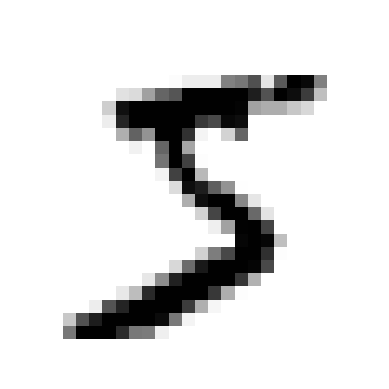

#### MNIST 데이터의 각 픽셀 중요도 알아보기
이번에는 MNIST 데이터셋에 랜덤 포레스트 분류기를 학습 시키고, 각 픽셀을 하나의 특성으로 보고 각 픽셀의 중요도를 그래프로 나타내보자.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

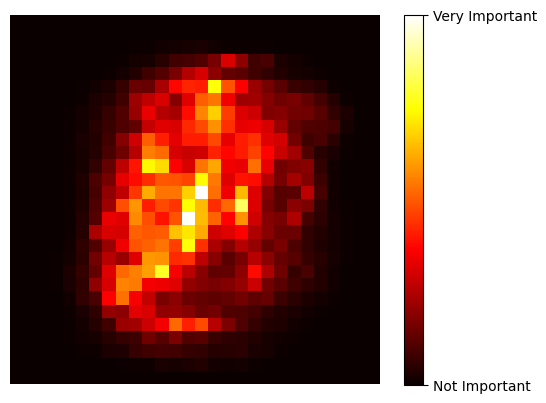

## 2) 이진 분류기 훈련
숫자가 5인지 아닌지를 분류하는 **이진 분류기**(binary classifier)를 분류해본다.

### 교차 검증을 사용한 정확도 측정

아래의 예제코드는 위의 `cross_val_score`과 같은 기능을 하는 교차 검증 기능을 `StratifiedKFold`를 이용해 직접 구현한 코드이다. `StratifiedKFold`는 클래스별 비율이 유지되도록 폴드(Fold)를 만들기 위해 계층적 샘플링을 수행한다.

출력 결과는 위의 결과와 동일한 결과가 출력된다.

In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# skfolds = StratifiedKFold(n_splits=3, random_state=42)
skfolds = StratifiedKFold(n_splits=3, random_state=None)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)  # sgd_clf 복제
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

NameError: ignored